In this notebook, I graph the different losses (from predicted values to test set values) for the two different best performing models based on different categorizations (region and type of event). Overall, the worst performing category is severe wind, with the subcategory of east severe wind performing the worst. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import math
import innvestigate as inv
import keras
import xarray as xr

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-07-11 22:41:22.624000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df_olr = xr.load_dataset('df_olr.nc') 
df_wg = xr.load_dataset('df_era5.nc')
pph_data = pd.read_csv('pph_loc_mean.csv').rename(columns={'Unnamed: 0': 'date'}).set_index('date')

label_list = list(np.datetime_as_string(df_olr.time.values))
for i, val in enumerate(label_list):
    label_list[i] = val.split('T')[0]

In [4]:
HORIZON = 7 # PPH from 7 days afterwords
WINDOW = 30 # assumes sliding in days
test_labels = label_list[label_list.index('2016-11-01'):label_list.index('2019-05-31')]

# creates a expanding window from given label -- WORKS!
def get_window_expanding(label="", label_list=label_list):
    try:
        # take the season
        # season_index = label_list.index(label)

        # grab all the days previous to one that you have
        window = [0]*(len(label_list)-7)
        for i in range(len(window)):
            window[i] = label_list[len(label_list)-i-8]
        # return window and label
        return window, label
        
    
    #printing error when value is not in seasons list
    except:
        return "Label not found in list"
    

# creates a sliding window from given label -- WORKS!
def get_window_sliding (label="", window_num=WINDOW):
    try: 
        #ensure not grabbing from diff season
        day_index = label_list.index(label)
        m = int(label.split('-')[1])
        d = int(label.split('-')[2])

        #for values that are almost outside the season, use and expanding window 
        if (m ==11 ) or (m ==12 and d < 7):
            y = label.split('-')[0]
            stopper = y+'-11-01' #end of the season
            stop_index = label_list.index(stopper)

            #creates a new list to grab data from
            label_list_copy = label_list.copy()[stop_index:day_index+1]

            return (get_window_expanding(label=label, label_list=label_list_copy))

        else:
            window = [0]*(window_num)

            for i in range(len(window)):
                window[i] = label_list[day_index-i-7] #TODO: 7 days between or pph_day - last_day = 7
            return window, label  
    
    except:
        return "Label not found in list"
    

# returns wind and geopotential dataframe for prev 30 days (minus 7d), olr dataframe for prev 30 days(minus 7d), 
# and pph data for the given date
def get_data(date):
    dates = get_window_sliding(date)
    past_dates = dates[0]
    target_data = pph_data.loc[date]
    # print(len(past_dates))
    if len(past_dates) == 0:
        return [], [], target_data
    slicer = slice(past_dates[-1], past_dates[0])

    return df_wg.sel(time=slicer), df_olr.sel(time=slicer), target_data




In [5]:
#building testing datasets
test_era5_data = np.zeros((635, 30, 51, 241, 2))
for i, val in enumerate(test_labels):
    try:
        day_index = label_list.index(val)
        m = int(val.split('-')[1])
        d = int(val.split('-')[2])
        if len(get_data(val)[0].u250.values) == 0:
            test_era5_data[i,:,:,:, 0] = np.full((30, 51, 241), 0)
        
        elif(m ==11) or (m ==12 and d < 7):
            r = np.zeros((30, 51, 241))
            n = get_data(val)[0].u250.values
            r[0:len(n), :, :] = n
            r[len(n):, :, :] = np.full(((30-len(n)), 51, 241), 0)
            test_era5_data[i,:,:,:, 0] = r
        else:
            d = get_data(val)[0].u250.values
            test_era5_data[i,:,:,:, 0] = d
        # print(val)
    except Exception as e:
        test_era5_data[i,:,:,:, 0] = np.full((30, 51, 241), 0)

for i, val in enumerate(test_labels):
    try:
        day_index = label_list.index(val)
        m = int(val.split('-')[1])
        d = int(val.split('-')[2])
        if len(get_data(val)[0].z500.values) == 0:
            test_era5_data[i,:,:,:, 1] = np.full((30, 51, 241), 0)
        
        elif(m ==11) or (m ==12 and d < 7):
            r = np.zeros((30, 51, 241))
            n = get_data(val)[0].z500.values
            r[0:len(n), :, :] = n
            r[len(n):, :, :] = np.full(((30-len(n)), 51, 241), 0)
            test_era5_data[i,:,:,:, 1] = r
        else:
            d = get_data(val)[0].z500.values
            test_era5_data[i,:,:,:, 1] = d
        # print(val)
    except Exception as e:
        test_era5_data[i,:,:,:, 1] = np.full((30, 51, 241), 0)

test_olr_data = np.zeros((635, 30, 13, 144, 1))
for i, val in enumerate(test_labels):
    try:
        day_index = label_list.index(val)
        m = int(val.split('-')[1])
        d = int(val.split('-')[2])
        if len(get_data(val)[1].olr.values) == 0:
            test_olr_data[i,:,:,:,0] = np.full((30, 13, 144), 0)
        
        elif(m ==11) or (m ==12 and d < 7):
            r = np.zeros((30,  13, 144))
            n = get_data(val)[1].olr.values
            r[0:len(n), :, :] = n
            r[len(n):, :, :] = np.full(((30-len(n)), 13, 144), 0)
            test_olr_data[i,:,:,:,0] = r
        else:
            d = get_data(val)[1].olr.values
            test_olr_data[i,:,:,:,0] = d
        # print(val)
    except Exception as e:
        test_olr_data[i,:,:,:,0] = np.full((30, 13, 144), 0)

test_pph_data = np.zeros((635, 9))
for i, val in enumerate(test_labels):
    test_pph_data[i,:] = np.array(list(get_data(val)[2].to_dict().values()))

In [6]:
pph_data[-636:]

,west_tor,west_wind,west_hail,central_tor,central_wind,central_hail,east_tor,east_wind,east_hail
date,,,,,,,,,
2016-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2016-11-02,0.000000,0.000129,0.009150,0.000000,1.351910,1.339154,0.0,0.000000,0.000000
2016-11-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2016-11-04,0.000000,0.093275,0.412768,0.000000,0.000013,0.086616,0.0,0.000000,0.000000
2016-11-05,0.000000,0.000000,0.168041,0.000000,0.000000,0.029909,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2019-05-27,0.200550,0.038387,0.274401,3.712219,4.844967,5.126097,0.0,0.000000,0.000000
2019-05-28,0.012979,0.002045,0.064389,1.073510,3.527014,5.957370,0.0,0.587768,0.000000
2019-05-29,0.000000,0.000008,0.000890,2.231628,5.683658,2.266128,0.0,0.000000,0.000000


In [33]:
np.shape(test_pph_data[:,0:3])

(635, 3)

In [7]:
model0931 = keras.models.load_model('my_model_0931.h5')
model095 = keras.models.load_model('my_model_095.h5')


# Show the model architecture
# model.summary()
# loss and accuracy in "new model"
# loss, acc = model.evaluate(X_validation, Y_validation, verbose=2)
# print('Restored model, categorical crossentropy: ', loss)
# print('Restored model, categorical accuracy: ', acc)

# 0931 Model

In [46]:
pred = model0931.predict([test_era5_data, test_olr_data])
pred

20/20 [==============================] - 240s 12s/step


array([[-0.04356998, -0.03091156, -0.0256471 , ..., -0.01283544,
         0.03068483, -0.01057875],
       [-0.04356998, -0.03091156, -0.0256471 , ..., -0.01283544,
         0.03068483, -0.01057875],
       [-0.04356998, -0.03091156, -0.0256471 , ..., -0.01283544,
         0.03068483, -0.01057875],
       ...,
       [-0.20753938,  0.04265032,  0.08729036, ...,  0.23868161,
        -0.8747734 , -0.6201932 ],
       [-0.18936479,  0.06770484,  0.10037456, ...,  0.2932947 ,
        -0.8707252 , -0.63595533],
       [-0.19612044,  0.0621591 ,  0.09652372, ...,  0.3072805 ,
        -0.8664036 , -0.6346927 ]], dtype=float32)

## REGIONAL DIFFERENCES

### West

variance: 0.012014641842477834
mean: -0.055462823069828734


(array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 9.000e+00,
        2.300e+01, 1.590e+02, 1.455e+03, 2.510e+02]),
 array([-1.52222054, -1.35154975, -1.18087896, -1.01020816, -0.83953737,
        -0.66886658, -0.49819579, -0.32752499, -0.1568542 ,  0.01381659,
         0.18448739]),
 <BarContainer object of 10 artists>)

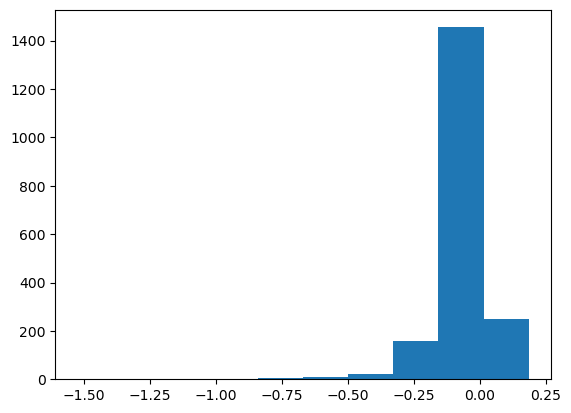

In [81]:
loss = pred-test_pph_data
w_loss = np.reshape(loss[:,0:3], (1905, 1))
c_loss = np.reshape(loss[:,3:6], (1905, 1))
e_loss = np.reshape(loss[:, 6:9], (1905, 1))
print("variance: "+str(np.var(w_loss)))
print("mean: "+str(np.mean(w_loss)))
plt.hist(w_loss)

### Central

variance: 1.2683515189588501
mean: -0.1606137925650942


(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 1.200e+01,
        2.900e+01, 6.100e+01, 3.250e+02, 1.471e+03]),
 array([-16.12894452, -14.33932366, -12.54970279, -10.76008193,
         -8.97046106,  -7.1808402 ,  -5.39121933,  -3.60159847,
         -1.8119776 ,  -0.02235674,   1.76726413]),
 <BarContainer object of 10 artists>)

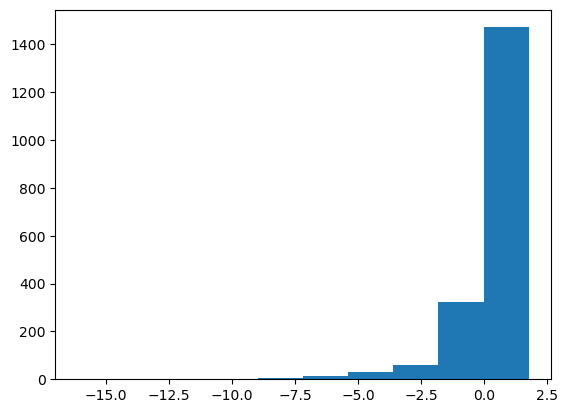

In [82]:
print("variance: "+str(np.var(c_loss)))
print("mean: "+str(np.mean(c_loss)))
plt.hist(c_loss)


### East

variance: 2.073674708370108
mean: -0.33436821861239047


(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        5.000e+00, 7.000e+00, 5.000e+01, 1.836e+03]),
 array([-28.95550421, -26.00652224, -23.05754028, -20.10855831,
        -17.15957634, -14.21059437, -11.2616124 ,  -8.31263044,
         -5.36364847,  -2.4146665 ,   0.53431547]),
 <BarContainer object of 10 artists>)

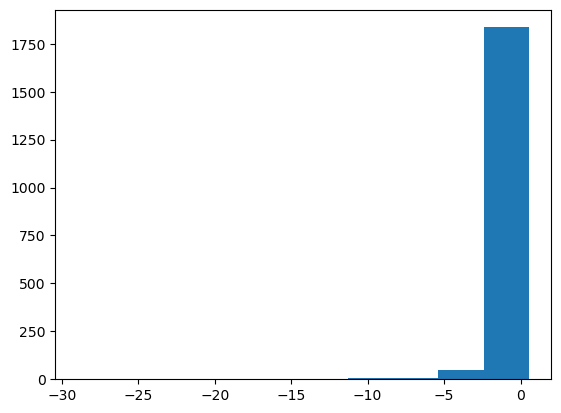

In [83]:
print("variance: "+str(np.var(e_loss)))
print("mean: "+str(np.mean(e_loss)))
plt.hist(e_loss)

## SEVERE EVENT DISTRIBUTIONS 

### Tornado

variance: 0.2882145380456946
mean: -0.06135400339060761


(array([1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 6.000e+00,
        1.600e+01, 1.300e+01, 1.180e+02, 1.744e+03]),
 array([-8.80519245, -7.85177276, -6.89835306, -5.94493337, -4.99151367,
        -4.03809398, -3.08467428, -2.13125458, -1.17783489, -0.22441519,
         0.7290045 ]),
 <BarContainer object of 10 artists>)

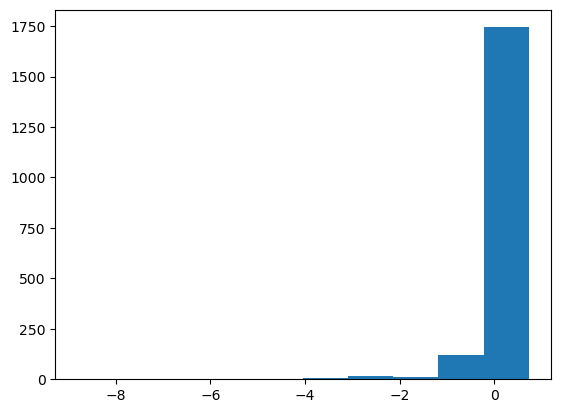

In [84]:
t_loss = np.reshape(loss[:, [0, 3, 6]], (1905, 1))
wi_loss = np.reshape(loss[:, [1, 4, 7]], (1905, 1))
h_loss = np.reshape(loss[:, [2, 5, 8]], (1905, 1))

print("variance: "+str(np.var(t_loss)))
print("mean: "+str(np.mean(t_loss)))
plt.hist(t_loss)

### Severe Wind

variance: 2.243096618978362
mean: -0.3238367535335388


(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        4.000e+00, 1.500e+01, 6.700e+01, 1.812e+03]),
 array([-28.95550421, -25.92482599, -22.89414777, -19.86346956,
        -16.83279134, -13.80211312, -10.7714349 ,  -7.74075668,
         -4.71007846,  -1.67940024,   1.35127797]),
 <BarContainer object of 10 artists>)

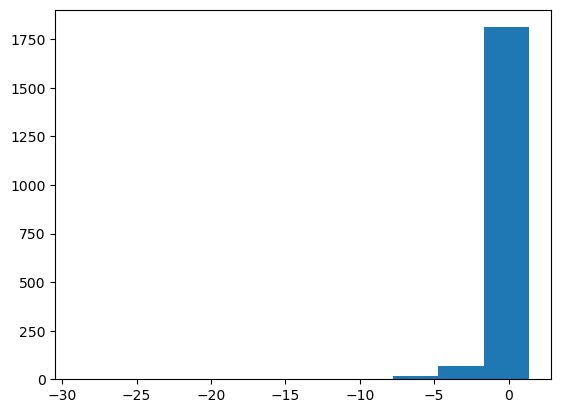

In [85]:
print("variance: "+str(np.var(wi_loss)))
print("mean: "+str(np.mean(wi_loss)))
plt.hist(wi_loss)

#### Doing regional distribution of severe wind because it has the highest variance

variance west wind: 0.012892305290971335
mean west wind: -0.056094028982919736


(array([  1.,   0.,   0.,   1.,   2.,   3.,   8.,  23., 505.,  92.]),
 array([-1.52222054, -1.35239949, -1.18257844, -1.01275739, -0.84293634,
        -0.67311528, -0.50329423, -0.33347318, -0.16365213,  0.00616892,
         0.17598998]),
 <BarContainer object of 10 artists>)

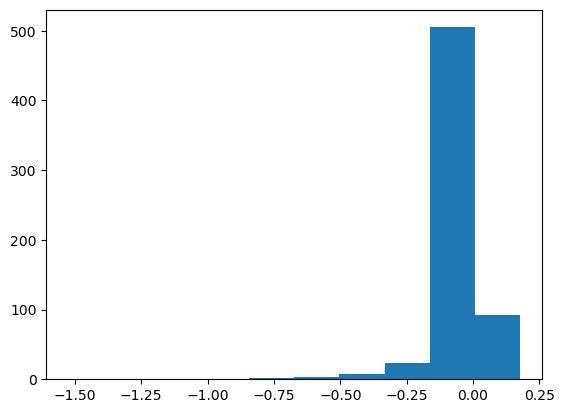

In [95]:
wiw = np.reshape(loss[:, [1]], (635, 1))
print("variance west wind: "+str(np.var(wiw[:, 0])))
print("mean west wind: "+str(np.mean(wiw[:, 0])))
plt.hist(wiw[:, 0])

variance west wind: 2.1866464721777823
mean west wind: -0.31963187300961093


(array([  1.,   0.,   0.,   1.,   1.,   8.,  15.,  26.,  65., 518.]),
 array([-16.12894452, -14.38092227, -12.63290002, -10.88487777,
         -9.13685552,  -7.38883327,  -5.64081102,  -3.89278877,
         -2.14476653,  -0.39674428,   1.35127797]),
 <BarContainer object of 10 artists>)

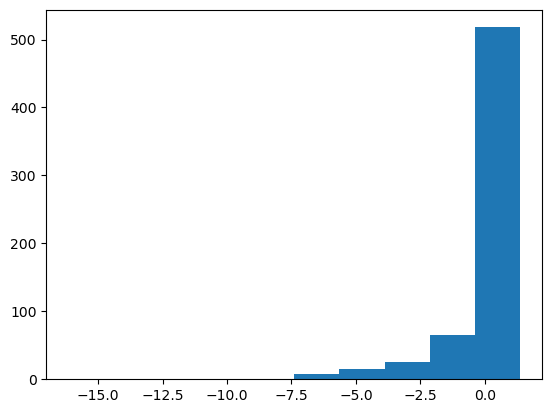

In [96]:
wic = np.reshape(loss[:, [4]], (635, 1))
print("variance central wind: "+str(np.var(wic[:, 0])))
print("mean central wind: "+str(np.mean(wic[:, 0])))
plt.hist(wic[:, 0])

variance east wind: 4.3840917319905435
mean east wind: -0.5957843586080855


(array([  1.,   0.,   2.,   0.,   2.,   1.,   3.,   1.,  16., 609.]),
 array([-28.95550421, -26.05131544, -23.14712667, -20.24293789,
        -17.33874912, -14.43456035, -11.53037157,  -8.6261828 ,
         -5.72199403,  -2.81780525,   0.08638352]),
 <BarContainer object of 10 artists>)

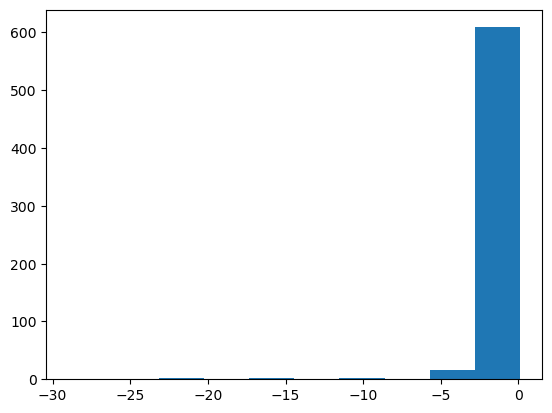

In [97]:
wie = np.reshape(loss[:, [7]], (635, 1))
print("variance east wind: "+str(np.var(wie[:, 0])))
print("mean east wind: "+str(np.mean(wie[:, 0])))
plt.hist(wie[:, 0])

### Hail

variance: 0.8274612661272931
mean: -0.16525407732316702


(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 7.000e+00,
        1.400e+01, 3.400e+01, 4.310e+02, 1.415e+03]),
 array([-16.73774988, -14.88724848, -13.03674708, -11.18624568,
         -9.33574428,  -7.48524288,  -5.63474148,  -3.78424008,
         -1.93373867,  -0.08323727,   1.76726413]),
 <BarContainer object of 10 artists>)

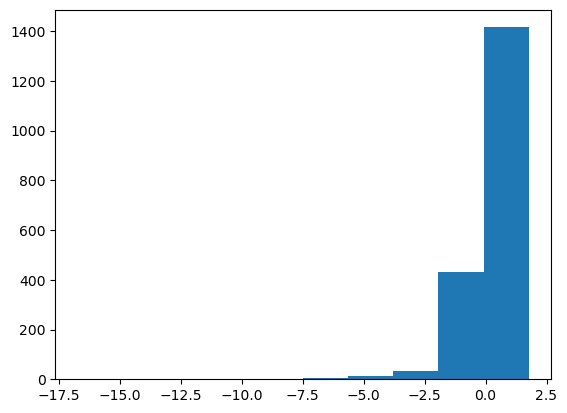

In [86]:
print("variance: "+str(np.var(h_loss)))
print("mean: "+str(np.mean(h_loss)))
plt.hist(h_loss)

# 095 Model

In [8]:
pred = model095.predict([test_era5_data, test_olr_data])
pred

20/20 [==============================] - 154s 8s/step


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

variance: 0.008694742563123557
mean: -0.0198891922644252


(array([1.00e+00, 2.00e+00, 0.00e+00, 1.00e+00, 4.00e+00, 2.00e+00,
        1.30e+01, 8.00e+00, 5.40e+01, 1.82e+03]),
 array([-1.52236925, -1.36699163, -1.21161401, -1.05623639, -0.90085876,
        -0.74548114, -0.59010352, -0.4347259 , -0.27934827, -0.12397065,
         0.03140697]),
 <BarContainer object of 10 artists>)

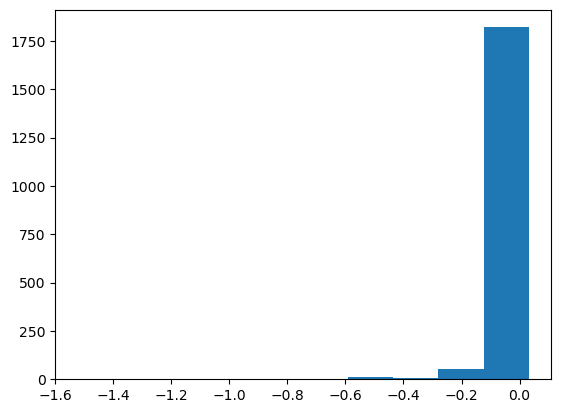

In [9]:
loss = pred-test_pph_data
w_loss = np.reshape(loss[:,0:3], (1905, 1))
c_loss = np.reshape(loss[:,3:6], (1905, 1))
e_loss = np.reshape(loss[:, 6:9], (1905, 1))
print("variance: "+str(np.var(w_loss)))
print("mean: "+str(np.mean(w_loss)))
plt.hist(w_loss)

variance: 1.2671331818458118
mean: -0.22342284961679634


(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 1.100e+01,
        2.900e+01, 5.900e+01, 2.320e+02, 1.567e+03]),
 array([-16.11543895, -14.35138574, -12.58733252, -10.8232793 ,
         -9.05922608,  -7.29517287,  -5.53111965,  -3.76706643,
         -2.00301321,  -0.23896   ,   1.52509322]),
 <BarContainer object of 10 artists>)

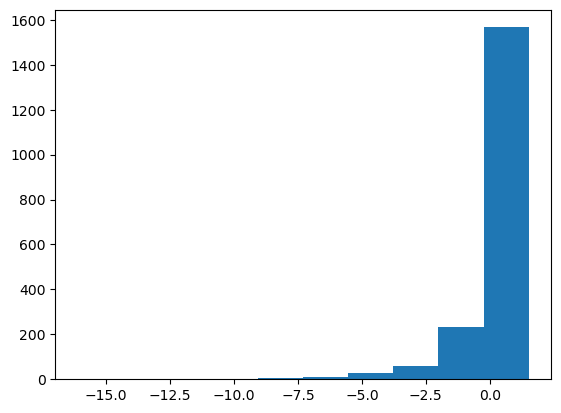

In [10]:
print("variance: "+str(np.var(c_loss)))
print("mean: "+str(np.mean(c_loss)))
plt.hist(c_loss)

variance: 1.9065472082480195
mean: -0.21297376800208734


(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        5.000e+00, 5.000e+00, 2.600e+01, 1.862e+03]),
 array([-2.82417764e+01, -2.54149915e+01, -2.25882065e+01, -1.97614216e+01,
        -1.69346366e+01, -1.41078517e+01, -1.12810667e+01, -8.45428175e+00,
        -5.62749679e+00, -2.80071184e+00,  2.60731187e-02]),
 <BarContainer object of 10 artists>)

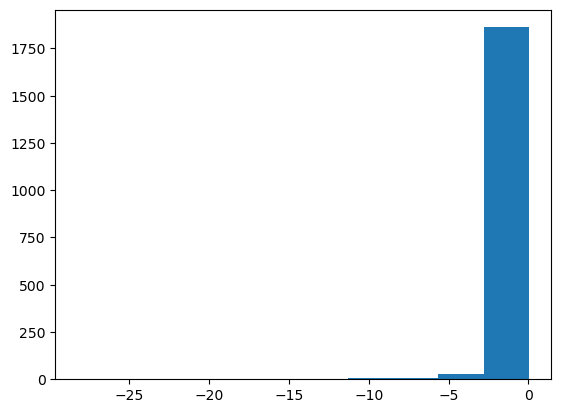

In [11]:
print("variance: "+str(np.var(e_loss)))
print("mean: "+str(np.mean(e_loss)))
plt.hist(e_loss)

variance: 0.28374502614799
mean: -0.07420331464448976


(array([1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 7.000e+00,
        1.600e+01, 1.200e+01, 4.400e+01, 1.818e+03]),
 array([-8.77082906, -7.83798894, -6.90514881, -5.97230869, -5.03946856,
        -4.10662844, -3.17378832, -2.24094819, -1.30810807, -0.37526794,
         0.55757218]),
 <BarContainer object of 10 artists>)

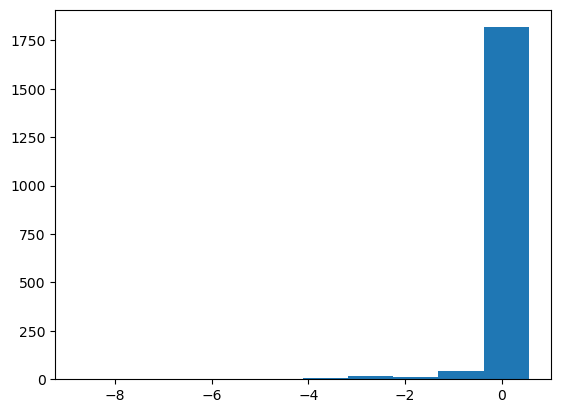

In [12]:
t_loss = np.reshape(loss[:, [0, 3, 6]], (1905, 1))
wi_loss = np.reshape(loss[:, [1, 4, 7]], (1905, 1))
h_loss = np.reshape(loss[:, [2, 5, 8]], (1905, 1))

print("variance: "+str(np.var(t_loss)))
print("mean: "+str(np.mean(t_loss)))
plt.hist(t_loss)

variance: 2.124466750602473
mean: -0.2517286947984754


(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        4.000e+00, 1.600e+01, 6.200e+01, 1.816e+03]),
 array([-28.24177644, -25.3079161 , -22.37405576, -19.44019542,
        -16.50633509, -13.57247475, -10.63861441,  -7.70475407,
         -4.77089373,  -1.83703339,   1.09682695]),
 <BarContainer object of 10 artists>)

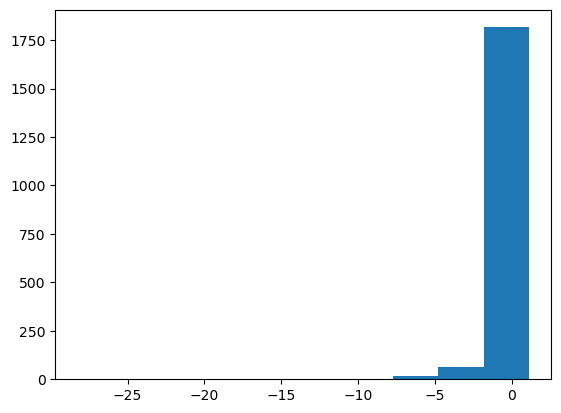

In [13]:
print("variance: "+str(np.var(wi_loss)))
print("mean: "+str(np.mean(wi_loss)))
plt.hist(wi_loss)

variance: 4.112782035222586
mean: -0.34138536531096486


(array([  1.,   0.,   1.,   1.,   2.,   1.,   3.,   1.,   8., 617.]),
 array([-28.24177644, -25.4175988 , -22.59342115, -19.76924351,
        -16.94506586, -14.12088822, -11.29671058,  -8.47253293,
         -5.64835529,  -2.82417764,   0.        ]),
 <BarContainer object of 10 artists>)

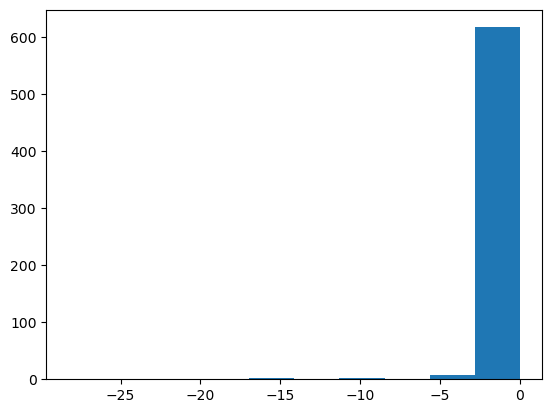

In [15]:
wie_loss = np.reshape(loss[:, [7]], (635, 1))
print("variance: "+str(np.var(wie_loss)))
print("mean: "+str(np.mean(wie_loss)))
plt.hist(wie_loss)

variance: 0.7839689504849054
mean: -0.13035380044034373


(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 6.000e+00,
        1.500e+01, 3.700e+01, 1.110e+02, 1.732e+03]),
 array([-16.35590143, -14.56780196, -12.7797025 , -10.99160303,
         -9.20350357,  -7.4154041 ,  -5.62730464,  -3.83920517,
         -2.05110571,  -0.26300624,   1.52509322]),
 <BarContainer object of 10 artists>)

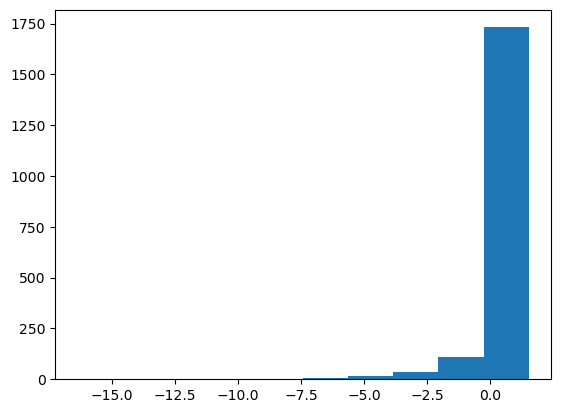

In [14]:
print("variance: "+str(np.var(h_loss)))
print("mean: "+str(np.mean(h_loss)))
plt.hist(h_loss)